# Use Case: Fingerprint Denoising and Inpainting using Fully Convolutional Networks

Let's implement the CNN architecture describe in this [paper](https://arxiv.org/abs/1807.11888) to play around with convolutional networks. As we will see at the end of the exercise, CNNs can be successfully applied to denoise and reconstruct missing parts of any image (fingerprints in this case)!


## The Dataset

The dataset consists of 84k synthetic fingerprint images. Images were generated using [Anguli](http://dsl.cds.iisc.ac.in/projects/Anguli/) and were degraded by adding random transformations (blur, brightness, contrast, elastic transformation, occlusion, scratch, resolution, rotation) and a background image.

Data is available in the following link:

- [training input](http://158.109.8.102/Inpainting/Track3/training_input.zip)

Download and unzip the data in an accessible path. Import the training, validation and test sets as follows:

In [2]:
from glob import glob
import numpy

data = list(zip(sorted(glob('../data/training_input/*.jpg')), sorted(glob('../data/training_ground-truth/*.jpg'))))
numpy.random.shuffle(data)
train_data_ = data[:int(len(data) * 0.8)]
numpy.random.shuffle(train_data_)
train_data = train_data_[:int(len(train_data_) * 0.8)]
val_data = train_data_[int(len(train_data_) * 0.8):]
test_data = data[int(len(data) * 0.8):]
batch_size = 8
print('Train size: %d\nValidation size: %d\nTest size: %d' % (len(train_data), len(val_data), len(test_data)))

Train size: 48384
Validation size: 12096
Test size: 15120


Populating the interactive namespace from numpy and matplotlib


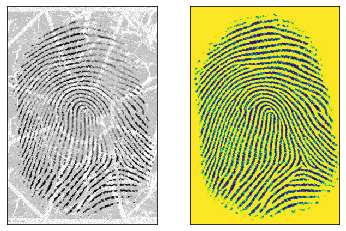

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as im

j = 1
ax = plt.subplot(1,2,j)
image = im.imread('../data/training_input/%s.jpg'%(1))
plot = plt.imshow(image)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
j += 1

ax = plt.subplot(1,2,j)
image = im.imread('../data/training_ground-truth/%s.jpg'%(1))
plot = plt.imshow(image)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
j += 1


## Preprocessing

Input images need to be processed:

- Data augmentation : to be performed during training only. The following lines of code satisfy such a requirement:

In [3]:
from keras_preprocessing import image
from PIL import Image
import cv2


def random_flip(img, mask, u=0.5):
    if np.random.random() < u:
        img = image.flip_axis(img, 1)
        mask = image.flip_axis(mask, 1)
    if np.random.random() < u:
        img = image.flip_axis(img, 0)
        mask = image.flip_axis(mask, 0)
    return img, mask

def random_rotate(img, mask, rotate_limit=(-20, 20), u=0.5):
    if np.random.random() < u:
        theta = np.pi / 180 * np.random.uniform(rotate_limit[0], rotate_limit[1])
        img = image.apply_affine_transform(img, theta=theta)
        mask = image.apply_affine_transform(mask, theta=theta)
    return img, mask

def shift(x, wshift, hshift, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = hshift * h
    ty = wshift * w
    x = image.apply_affine_transform(x, ty=ty, tx=tx)
    return x

def random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.5):
    if np.random.random() < u:
        wshift = np.random.uniform(w_limit[0], w_limit[1])
        hshift = np.random.uniform(h_limit[0], h_limit[1])
        img = shift(img, wshift, hshift)
        mask = shift(mask, wshift, hshift)
    return img, mask

def random_zoom(img, mask, zoom_range=(0.8, 1), u=0.5):
    if np.random.random() < u:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
        img = image.apply_affine_transform(img, zx=zx, zy=zy)
        mask = image.apply_affine_transform(mask, zx=zx, zy=zy)
    return img, mask



def random_shear(img, mask, intensity_range=(-0.5, 0.5), u=0.5):
    if np.random.random() < u:
        sh = np.random.uniform(-intensity_range[0], intensity_range[1])
        img = image.apply_affine_transform(img, shear=sh)
        mask = image.apply_affine_transform(mask, shear=sh)
    return img, mask

def random_gray(img, u=0.5):
    if np.random.random() < u:
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = np.sum(img * coef, axis=2)
        img = np.dstack((gray, gray, gray))
    return img

def random_contrast(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = img * coef
        gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
        img = alpha * img + gray
        img = np.clip(img, 0., 1.)
    return img

def random_brightness(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        img = alpha * img
        img = np.clip(img, 0., 1.)
    return img

def random_saturation(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])
        gray = img * coef
        gray = np.sum(gray, axis=2, keepdims=True)
        img = alpha * img + (1. - alpha) * gray
        img = np.clip(img, 0., 1.)
    return img

def random_channel_shift(x, limit, channel_axis=2):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_ch + np.random.uniform(-limit, limit), min_x, max_x) for x_ch in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def random_crop(img, mask, u=0.1):
    if np.random.random() < u:
        w, h = img.shape[0], img.shape[1]
        offsetw = np.random.randint(w//2)
        offseth = np.random.randint(w//2)

        endw = np.random.randint(w // 2)+w // 2
        endh = np.random.randint(w // 2)+w // 2

        new_im = img[offsetw:offsetw + endw, offseth:offseth + endh, :]
        new_mask = mask[offsetw:offsetw + endw, offseth:offseth + endh, :]

        new_im, new_mask = cv2.resize(new_im, interpolation = cv2.INTER_LINEAR, dsize=(w, h)), \
               cv2.resize(new_mask, interpolation=cv2.INTER_LINEAR, dsize=(w, h))

        new_mask = new_mask[..., np.newaxis]
        return new_im, new_mask
    else:
        return img, mask


def random_augmentation(img, mask):
    img = random_channel_shift(img, limit=0.1)
    img = random_brightness(img, limit=(-0.05, 0.05), u=0.1)
    img = random_contrast(img, limit=(-0.05, 0.05), u=0.1)
    img = random_saturation(img, limit=(-0.05, 0.05), u=0.1)
    img = random_gray(img, u=0.1)
    img, mask = random_rotate(img, mask, rotate_limit=(-5, 5), u=0.1)
    img, mask = random_shear(img, mask, intensity_range=(-0.05, 0.05), u=0.1)
    img, mask = random_flip(img, mask, u=0.5)
    img, mask = random_shift(img, mask, w_limit=(-0.05, 0.05), h_limit=(-0.05, 0.05), u=0.1)
    img, mask = random_zoom(img, mask, zoom_range=(0.95, 1.05), u=0.1)
    return img, mask

- Normalization : Divide pixel intensities by 255 so they are in the (0, 1) range.

In [4]:
def read_input(path):
    x = resize(cv2.imread(path)/255., input_shape)
    return np.asarray(x)

def read_gt(path):
    y = resize(cv2.imread(path, 0)/255., input_shape)
    return np.asarray(y)[..., np.newaxis]

Add these preprocessing steps into a function to generate the final data:

In [5]:
def gen(data):
    while True:
        index= random.choice(list(range(len(data))), batch_size)
        index = list(map(int, index))
        list_images_base = [read_input(data[i][0]) for i in index]
        list_gt_base = [read_gt(data[i][1]) for i in index]


        list_images_aug = []
        list_gt_aug = []

        for image_, gt in zip(list_images_base, list_gt_base):
            image_aug, gt = random_augmentation(image_, gt) #image_, gt

            list_images_aug.append(image_aug)
            list_gt_aug.append(gt)

        yield np.array(list_images_aug), np.array(list_gt_aug)

## Model

![Alt text](../imgs/15_CNN_Fingerprint_architecture.png)

Implement the above U-net based architecture using keras:

In [6]:
from keras.layers import Input, MaxPooling2D
from keras.layers import concatenate, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, PReLU, ReLU
from keras.models import Model
from keras.activations import relu
from keras.optimizers import Adam
from numpy import random

Using TensorFlow backend.


In [7]:
def Unet(do=0, activation=ReLU):
    inputs = Input(input_shape+(3,))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(inputs)))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(pool1)))
    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(pool2)))
    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(pool3)))
    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(pool4)))
    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(conv5)))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(up6)))
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv6)))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(up7)))
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv7)))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(up8)))
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv8)))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(up9)))
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv9)))

    conv10 = Dropout(do)(Conv2D(1, (1, 1), activation='sigmoid')(conv9))

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=losses.mse)

    model.summary()

    return model

## Train the model

Use Adam optimizer with an initial learning rate of 1e-4 (reduced this learning rate by a factor of 0.5 each time the validation loss plateaued for more than 3 epochs)

Learning is stopped if the validation loss does not improve for the last 5 epochs.


In [8]:
# part of this script was taken from https://github.com/jocicmarko/ultrasound-nerve-segmentation
import os
import argparse
import pandas as pd
from keras import backend as K
from keras import losses
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from skimage.transform import resize
from sklearn.model_selection import train_test_split

input_shape = (400, 288)
smooth = 1.
dropout = 0
if not os.path.exists("../models/"):
    os.makedirs("../models/")
    
model_name = "../models/baseline_unet_aug_do_%s_activation_%s_"%(dropout, 'ReLu')
print("Model : %s"%model_name)


def custom_activation(x):
    return K.relu(x, alpha=0.0, max_value=1)

model = Unet(do=dropout, activation=ReLU)

file_path = model_name + "weights.best.hdf5"
try:
    model.load_weights(file_path, by_name=True)
except:
    pass


checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_loss", mode="min", patience=3, verbose=1)
callbacks_list = [checkpoint, early, redonplat]  # early

history = model.fit_generator(gen(train_data), validation_data=gen(val_data), epochs=5, verbose=1,
                     callbacks=callbacks_list, steps_per_epoch= len(train_data)//batch_size,
                              validation_steps=len(val_data)//batch_size, 
                              use_multiprocessing=False, workers=1)






Model : ../models/baseline_unet_aug_do_0_activation_ReLu_
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 288, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 288, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 400, 288, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 400, 288, 32) 0           re_lu_1[0][0]                    
___________________________________________________

Epoch 1/5


/home/juan/.opt/anaconda/envs/ks_dl_course/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/juan/.opt/anaconda/envs/ks_dl_course/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


7560/7560 [==============================] - 2604s 344ms/step - loss: 0.0262 - val_loss: 0.0233

Epoch 00001: val_loss improved from inf to 0.02327, saving model to ../models/baseline_unet_aug_do_0_activation_ReLu_weights.best.hdf5
Epoch 2/5
7560/7560 [==============================] - 2323s 307ms/step - loss: 0.0220 - val_loss: 0.0214

Epoch 00002: val_loss improved from 0.02327 to 0.02144, saving model to ../models/baseline_unet_aug_do_0_activation_ReLu_weights.best.hdf5
Epoch 3/5
7560/7560 [==============================] - 2320s 307ms/step - loss: 0.0210 - val_loss: 0.0220

Epoch 00003: val_loss did not improve from 0.02144
Epoch 4/5
7560/7560 [==============================] - 2600s 344ms/step - loss: 0.0204 - val_loss: 0.0207

Epoch 00004: val_loss improved from 0.02144 to 0.02074, saving model to ../models/baseline_unet_aug_do_0_activation_ReLu_weights.best.hdf5
Epoch 5/5
7560/7560 [==============================] - 2474s 327ms/step - loss: 0.0201 - val_loss: 0.0202

Epoch 00005

## Results

Make some predictions and visualize the results:

/home/juan/.opt/anaconda/envs/ks_dl_course/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/juan/.opt/anaconda/envs/ks_dl_course/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


('../data/training_input/7783.jpg', '../data/training_ground-truth/7783.jpg')


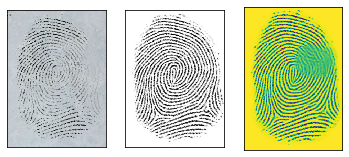

('../data/training_input/32528.jpg', '../data/training_ground-truth/32528.jpg')


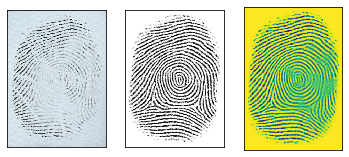

('../data/training_input/33479.jpg', '../data/training_ground-truth/33479.jpg')


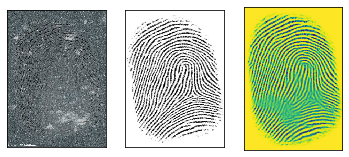

('../data/training_input/60411.jpg', '../data/training_ground-truth/60411.jpg')


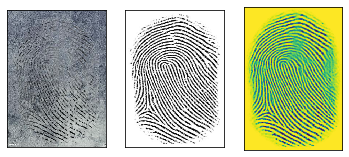

('../data/training_input/32419.jpg', '../data/training_ground-truth/32419.jpg')


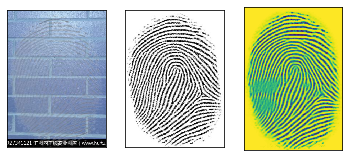

('../data/training_input/31231.jpg', '../data/training_ground-truth/31231.jpg')


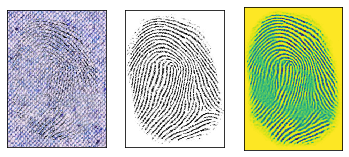

('../data/training_input/4963.jpg', '../data/training_ground-truth/4963.jpg')


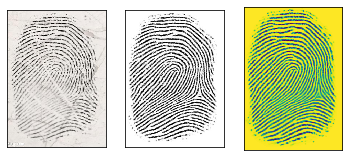

('../data/training_input/10930.jpg', '../data/training_ground-truth/10930.jpg')


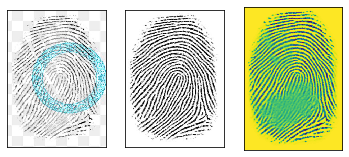

('../data/training_input/52117.jpg', '../data/training_ground-truth/52117.jpg')


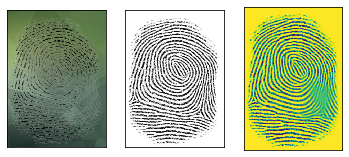

('../data/training_input/34713.jpg', '../data/training_ground-truth/34713.jpg')


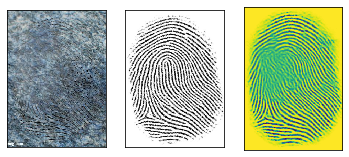

In [9]:
from cv2 import imread
from skimage.morphology import label
from pycocotools import mask as maskUtils
from tqdm import tqdm

test_files = test_data[:10]
try:
    os.mkdir("outputs/"+model_name)
except:
    pass

model.load_weights(file_path)

for i, image_path in enumerate(test_files):
    print(image_path)
    imgs = [resize(imread(image_path[0])/255., input_shape)]
    imgs = np.array(imgs)
    imgs_truth = [resize(imread(image_path[1])/255., input_shape)]
    imgs_truth = np.array(imgs_truth)



    pred = model.predict(imgs)

    pred_all = (pred)

    pred = np.clip(pred, 0, 1)
    pred_ = pred[0, :, :, 0]
    pred_ = resize(pred_, (400, 275))

    pred_ = 255.*(pred_ - np.min(pred_))/(np.max(pred_)-np.min(pred_))

    j = 1
    ax = plt.subplot(1,3,j)
    plot = plt.imshow(imgs[0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j += 1

    ax = plt.subplot(1,3,j)
    plot = plt.imshow(imgs_truth[0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j += 1

    ax = plt.subplot(1,3,j)
    plot = plt.imshow(pred_)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j += 1
    plt.show()





## References

https://towardsdatascience.com/fingerprint-denoising-and-inpainting-using-fully-convolutional-networks-e24714c3233